# Exploring Feature Importance and Feature Interaction

This notebook explores ideas around Feature Importance and Feature Interaction by generating a synthetic data set with fetures of different feature importance and interactivity. Its purpose is to validate using methods of feature importance and to explore methods of discovering features which have strong interaction with other features.

A lot of these ideas come from the excellent 'fastai' course 'Introduction to Machine Learning for Coders' http://course18.fast.ai/ml

In [287]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math

First create features from different random distributions. Features were designed to be roughly normalised with a range of [-1, 1]. Different distributions were used to see if this had an effect on feature importance.

In [288]:
n_samples = 10000

In [289]:
x = {f'x{i}': np.random.uniform(-1, 1, n_samples) for i in range(1, 21)}

Example of one of the uniformly distributed features

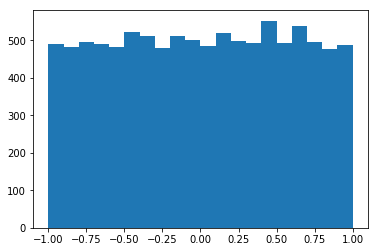

In [310]:
plt.hist(x['x1'], bins=20)
plt.show()

Now we create our independent variable 'y'. 

In [312]:
# Start with our strongest feature we want to see if we can find later x2-x1
y = x['x1'] + x['x11']
y += 2*x['x2'] + 2*x['x12']
y += 3*x['x3'] + 3*x['x13']
y += 4*x['x4'] + 4*x['x14']
y += 5*x['x5'] + 5*x['x15']
y += 6*x['x6'] + 6*x['x16']
y += 7*x['x7'] + 7*x['x17']
y += 8*x['x8'] + 8*x['x18']
y += 9*x['x9'] + 7*x['x19']
y += 0*x['x10'] + 0*x['x20']

# Add a bias
y += 50

# Add some random noise
y += np.random.normal(0, 1, y.shape)

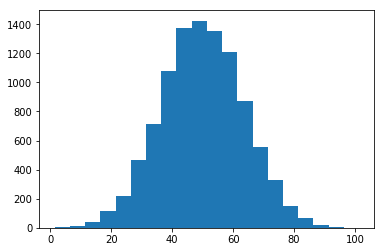

In [313]:
plt.hist(y, bins=20)
plt.show()

In [314]:
y.min(), y.max()

(1.470171653316485, 101.32037155180417)

stack all of our independent variables x1, x2, ..., x10 into a pd data frame. So that we can input them into our model

In [315]:
x = pd.DataFrame(x).sample(frac=1.0, axis=1)

In [316]:
x.head()

,x13,x5,x19,x1,x10,x4,x20,x3,x14,x2,x9,x17,x12,x15,x16,x18,x8,x7,x6,x11
0,-0.229548,-0.511961,-0.554082,0.810380,-0.001181,-0.516537,-0.208066,0.588470,0.613874,-0.624299,-0.305467,0.122504,0.216160,-0.897023,0.942305,0.072966,-0.641547,0.957575,-0.861689,0.513301
1,0.128942,-0.385446,-0.559927,0.881398,-0.255468,-0.465530,0.324536,0.032694,-0.951808,0.541182,-0.422273,0.902730,0.622043,0.478477,-0.515317,0.744269,-0.936595,0.372141,-0.484920,0.716704
2,-0.900413,-0.506555,0.920853,-0.763834,0.587156,0.553854,0.157944,-0.471981,-0.883142,-0.718099,-0.937962,-0.601910,-0.956719,-0.128811,0.925158,-0.149800,0.080394,-0.082414,-0.756695,0.803056
3,-0.871692,-0.093086,0.202133,-0.303231,-0.451197,-0.727145,-0.894082,0.361176,-0.140464,-0.567420,0.630076,-0.221173,0.798515,0.021971,-0.065988,0.881250,-0.107062,-0.756439,0.609930,-0.706941
4,0.221549,0.609153,-0.691213,0.558895,0.287208,0.387309,0.435158,-0.629387,0.285235,-0.611154,0.522291,0.374852,0.863458,0.396703,-0.257818,0.441033,0.021124,0.595553,-0.104145,-0.156685


In [317]:
x.shape

(10000, 20)

Split dataset and labels into train, validate and test

In [318]:
x_trn, x_val, x_test = x.iloc[:8000, :], x.iloc[8000:9000, :], x.iloc[9000:, :]
y_trn, y_val, y_test = y[:8000], y[8000:9000], y[9000:]

In [319]:
x_trn.shape, x_val.shape, x_test.shape

((8000, 20), (1000, 20), (1000, 20))

In [320]:
y_trn.shape, y_val.shape, y_test.shape

((8000,), (1000,), (1000,))

Train a model

In [321]:
m = RandomForestRegressor(n_estimators=50).fit(x_trn, y_trn)

Score and evaluate the model

In [322]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, pass_back=False):
    res = [rmse(m.predict(x_trn), y_trn), rmse(m.predict(x_val), y_val),
                m.score(x_trn, y_trn), m.score(x_val, y_val)]
    print(f'Train RMSE: {round(res[0], 3)}')
    print(f'Validation RMSE: {round(res[1], 3)}')
    print(f'Train R-Squared: {round(res[2], 3)}')
    print(f'Validation R-Squared: {round(res[3], 3)}')
    if pass_back:
        return res

In [323]:
scores = print_score(m, pass_back=True)
val_rmse = scores[1]

Train RMSE: 2.351
Validation RMSE: 6.253
Train R-Squared: 0.969
Validation R-Squared: 0.792


Plot labels of training data vs predictions of training data

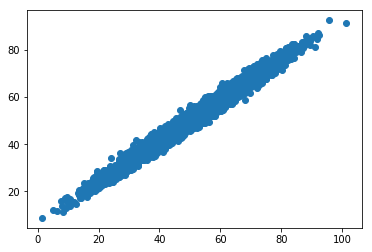

In [324]:
plt.scatter(y_trn, m.predict(x_trn))
plt.show()

Plot predictions of validation data vs true labels

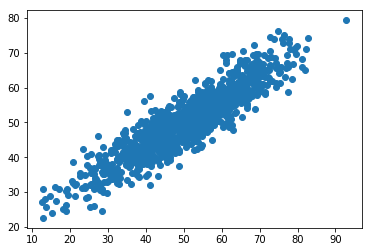

In [325]:
plt.scatter(y_val, m.predict(x_val))
plt.show()

Evaluate Feature importance - Go through the inputs to the model one at a time and shuffle the values of one column. Make predictions using the data with one row shuffled. Evaluate the effect on the models score rank each feature by how much the models score was negatively effected when removed 

* re-write above

In [326]:
df_importance = pd.DataFrame()
for col in x_val.columns:
    x_shuffle = x_val.copy()
    shuffled_column = x_shuffle[col].values
    np.random.shuffle(shuffled_column)
    x_shuffle[col] = shuffled_column
    rmse_score = rmse(y_val, m.predict(x_shuffle))
    row = {}
    row['col'] = col
    row['score'] = rmse_score
    df_importance = df_importance.append(row, ignore_index=True)

df_importance = df_importance.sort_values(by='score')

In [327]:
top_ten_fi_vars = df_importance.reset_index(drop=True).iloc[:20, 0].values

df_importance['error_diff'] = df_importance['score'] - val_rmse

error_diffs = {row['col']: row['error_diff'] for i, row in df_importance.iterrows()}

df_importance = df_importance.sort_values(by='error_diff', ascending=False)
df_importance.head(10)

,col,score,error_diff
10,x9,9.216710,2.964060
16,x8,8.755638,2.502987
15,x18,8.741041,2.488390
2,x19,8.117249,1.864599
17,x7,7.872137,1.619486
11,x17,7.688492,1.435841
14,x16,7.325197,1.072547
18,x6,7.240448,0.987797
13,x15,6.860528,0.607878
1,x5,6.763274,0.510623


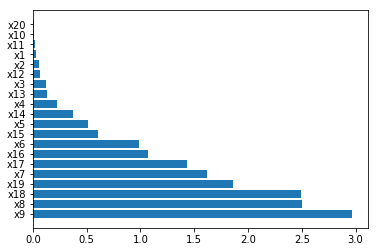

In [328]:
plt.barh(y=np.arange(20), width=df_importance['error_diff'], tick_label=df_importance['col'])
plt.show()

Using this we can see what variables are important and what are not important. The scores on the x axis are not as meaningful as comparing each variable to each other